# Random Forest Hyperparameter Analysis Framework

This notebook provides a comprehensive framework for analyzing the impact of various Random Forest hyperparameters on model performance. The analysis explores:

1. **Tree Depth Impact**: From minimal trees (underfitting) to deep trees (overfitting)
2. **Feature Selection Impact**: Number of randomly selected features for splits
3. **Interaction Effects**: Combined impact of depth and feature selection
4. **Dataset Complexity**: Analysis across multiple datasets of varying complexity

## Framework Structure:
- **Section 1**: Data Loading and Preprocessing
- **Section 2**: Random Forest Implementation and Utilities
- **Section 3**: Experiment 1 - Tree Depth Analysis
- **Section 4**: Experiment 2 - Feature Selection Analysis  
- **Section 5**: Experiment 3 - Interaction Analysis
- **Section 6**: Results Visualization and Analysis
- **Section 7**: Conclusions and Discussion

In [25]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, load_breast_cancer, load_wine
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
import os
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [76]:
# ...existing code...
IEEE_SINGLE_COL = 3.5   # in
IEEE_DOUBLE_COL = 7.16  # in

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ['Times New Roman', 'Times', 'TeX Gyre Termes', 'Nimbus Roman No9 L', 'DejaVu Serif'],
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{newtxtext}\usepackage{newtxmath}",

    # Doubled font sizes
    "axes.labelsize": 18,
    "axes.titlesize": 18,
    "axes.labelweight": "normal",
    "axes.labelpad": 12,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
    "legend.title_fontsize": 16,

    # Ticks and lines (doubled)
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.color": "black",
    "ytick.color": "black",
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "lines.linewidth": 2.8,
    "lines.markersize": 9.0,
    "errorbar.capsize": 6,

    # Figure and save settings (keep column-native sizes)
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "figure.figsize": (IEEE_SINGLE_COL, IEEE_SINGLE_COL * 0.62),  # default single-column
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.01,
})

# REMOVE these overrides (they break IEEE sizing):
# plt.rcParams['figure.figsize'] = (8, 6)
# plt.rcParams.update(plt.rcParams)
# ...existing code...

## Section 1: Data Loading and Preprocessing

We'll work with three datasets of varying complexity:
1. **Simple Dataset**: Synthetic data with clear decision boundaries
2. **Medium Dataset**: Wine classification (moderate complexity)
3. **Complex Dataset**: Breast cancer classification

In [27]:
class DatasetManager:
    """Manages multiple datasets for Random Forest analysis"""
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.datasets = {}
        
    def load_datasets(self):
        """Load and prepare all datasets"""
        
        # 1. Simple Dataset: Synthetic with clear decision boundaries
        print("\n" + "=" * 80)
        print("DATASET 1: SIMPLE - Limited Overfitting Potential")
        print("=" * 80)
        X_simple, y_simple = make_classification(
            n_samples=500,         # Small dataset
            n_features=10,         # Few features
            n_informative=8,       # Most are informative
            n_redundant=2,
            n_classes=2,           # Binary classification (easier)
            class_sep=2.0,         # High separation - easy to classify
            flip_y=0.0,            # No noise - pure leaves possible
            random_state=42
        )
        print(f"Dataset: {X_simple.shape[0]} samples, {X_simple.shape[1]} features, 2 classes")
        print("Expected: Trees will stop growing early (~depth 10-15)")
        print("          Increasing max_depth won't increase overfitting\n")
        
        self.depth_range_simple = [1, 2, 3, 4, 5, 6, 8, 10, 12]
        self.datasets['simple'] = {
            'name': 'simple',
            'X': X_simple,
            'y': y_simple
        }
        # ========================================================================
        # DATASET 2: MEDIUM - Moderate overfitting potential
        # ========================================================================
        print("\n\n" + "=" * 80)
        print("DATASET 2: MEDIUM - Moderate Overfitting Potential")
        print("=" * 80)
        X_medium, y_medium = make_classification(
            n_samples=2000,        # Medium dataset
            n_features=25,         # Moderate features
            n_informative=18,
            n_redundant=5,
            n_classes=3,           # 3 classes
            class_sep=1.0,         # Medium separation
            flip_y=0.2,           # Small amount of noise
            random_state=42
        )
        print(f"Dataset: {X_medium.shape[0]} samples, {X_medium.shape[1]} features, 3 classes")
        print("Expected: Trees will grow to medium depths (~20-40)")
        print("          Some progressive overfitting visible\n")

        self.depth_range_medium = [1, 3, 5, 7, 10, 12, 15, 18, 20, 25, 30]
        self.datasets['medium'] = {
            'name': 'medium',
            'X': X_medium,
            'y': y_medium
        }
        


        # ========================================================================
        # DATASET 3: COMPLEX - Strong progressive overfitting
        # ========================================================================
        print("\n\n" + "=" * 80)
        print("DATASET 3: COMPLEX - Strong Progressive Overfitting")
        print("=" * 80)
        X_complex, y_complex = make_classification(
            n_samples=6000,        # Large dataset - more room to split
            n_features=50,         # Many features - more split options
            n_informative=35,      # Most features are informative
            n_redundant=10,        # Some redundancy
            n_classes=4,           # Multi-class makes it harder
            class_sep=0.7,         # Low separation - harder to split cleanly
            flip_y=0.3,           # 3% label noise - prevents pure leaves
            random_state=42
        )
        print(f"Dataset: {X_complex.shape[0]} samples, {X_complex.shape[1]} features, 4 classes")
        print("Expected: Trees will keep growing with higher max_depth")
        print("          Clear progressive overfitting from depth 100 to 120\n")

        self.depth_range_complex = [1, 3, 5, 7, 10, 12, 15, 20, 25, 30, 35, 40]
        self.datasets['complex'] = {
            'name': 'complex',
            'X': X_complex,
            'y': y_complex
        }
        
    def get_dataset_info(self):
        """Display information about all datasets"""
        for key, data in self.datasets.items():
            print(f"\n{data['name']}")
            print(f"  Features: {data['X'].shape[1]}")
            print(f"  Samples: {data['X'].shape[0]}")
            print(f"  Classes: {len(np.unique(data['y']))}")
            print(f"  Class distribution: {np.bincount(data['y'])}")
    
    def split_datasets(self, test_size=0.3):
        """Split all datasets into train/test sets"""
        self.splits = {}
        for key, data in self.datasets.items():
            X_train, X_test, y_train, y_test = train_test_split(
                data['X'], data['y'], 
                test_size=test_size, 
                random_state=self.random_state,
                stratify=data['y']
            )
            self.splits[key] = {
                'X_train': X_train, 'X_test': X_test,
                'y_train': y_train, 'y_test': y_test
            }
        print(f"Split {len(self.datasets)} datasets into train/test sets.")

# Initialize and load datasets
dataset_manager = DatasetManager(RANDOM_STATE)
dataset_manager.load_datasets()
dataset_manager.get_dataset_info()
dataset_manager.split_datasets()


DATASET 1: SIMPLE - Limited Overfitting Potential
Dataset: 500 samples, 10 features, 2 classes
Expected: Trees will stop growing early (~depth 10-15)
          Increasing max_depth won't increase overfitting



DATASET 2: MEDIUM - Moderate Overfitting Potential
Dataset: 2000 samples, 25 features, 3 classes
Expected: Trees will grow to medium depths (~20-40)
          Some progressive overfitting visible



DATASET 3: COMPLEX - Strong Progressive Overfitting
Dataset: 6000 samples, 50 features, 4 classes
Expected: Trees will keep growing with higher max_depth
          Clear progressive overfitting from depth 100 to 120


simple
  Features: 10
  Samples: 500
  Classes: 2
  Class distribution: [250 250]

medium
  Features: 25
  Samples: 2000
  Classes: 3
  Class distribution: [675 656 669]

complex
  Features: 50
  Samples: 6000
  Classes: 4
  Class distribution: [1461 1512 1521 1506]
Split 3 datasets into train/test sets.


In [28]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier


class RandomForestOverfit(BaseEstimator, ClassifierMixin):
    """
    A Random Forest configured to allow overfitting with tools to analyze
    overfitting behavior at different max_depth values.
    """
    def __init__(
        self,
        n_estimators=100,
        *,
        max_depth=None,
        max_features=None,
        bootstrap=True,
        random_state=None,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        criterion='gini',
        class_weight=None,
        splitter='best',
        ccp_alpha=0.0,
    ):
        self.n_estimators = int(n_estimators)
        self.max_depth = max_depth
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.max_leaf_nodes = max_leaf_nodes
        self.min_impurity_decrease = min_impurity_decrease
        self.criterion = criterion
        self.class_weight = class_weight
        self.splitter = splitter
        self.ccp_alpha = ccp_alpha
        self.estimators_ = []
        self.classes_ = None
        self.n_classes_ = None

    def get_params(self, deep=True):
        return {
            'n_estimators': self.n_estimators,
            'max_depth': self.max_depth,
            'max_features': self.max_features,
            'bootstrap': self.bootstrap,
            'random_state': self.random_state,
            'min_samples_split': self.min_samples_split,
            'min_samples_leaf': self.min_samples_leaf,
            'min_weight_fraction_leaf': self.min_weight_fraction_leaf,
            'max_leaf_nodes': self.max_leaf_nodes,
            'min_impurity_decrease': self.min_impurity_decrease,
            'criterion': self.criterion,
            'class_weight': self.class_weight,
            'splitter': self.splitter,
            'ccp_alpha': self.ccp_alpha,
        }

    def set_params(self, **params):
        for k, v in params.items():
            setattr(self, k, v)
        return self

    def _rng(self):
        return np.random.default_rng(self.random_state)

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self.classes_, y_enc = np.unique(y, return_inverse=True)
        self.n_classes_ = len(self.classes_)
        n_samples = X.shape[0]
        self.estimators_ = []

        rng = self._rng()
        for i in range(self.n_estimators):
            if self.bootstrap:
                indices = rng.integers(0, n_samples, size=n_samples)
            else:
                indices = np.arange(n_samples)

            tree = DecisionTreeClassifier(
                criterion=self.criterion,
                splitter=self.splitter,
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                min_weight_fraction_leaf=self.min_weight_fraction_leaf,
                max_features=self.max_features,
                random_state=int(rng.integers(0, 2**31 - 1)),
                max_leaf_nodes=self.max_leaf_nodes,
                min_impurity_decrease=self.min_impurity_decrease,
                class_weight=self.class_weight,
                ccp_alpha=self.ccp_alpha,
            )
            tree.fit(X[indices], y[indices])
            self.estimators_.append(tree)
        return self

    def _predict_proba_estimator(self, est, X):
        proba = est.predict_proba(X)
        if proba.shape[1] == self.n_classes_ and np.all(est.classes_ == self.classes_):
            return proba
        aligned = np.zeros((X.shape[0], self.n_classes_), dtype=float)
        for j, cls in enumerate(est.classes_):
            idx = np.where(self.classes_ == cls)[0][0]
            aligned[:, idx] = proba[:, j]
        return aligned

    def predict_proba(self, X):
        X = np.asarray(X)
        if not self.estimators_:
            raise ValueError("Estimator not fitted: call fit before predict_proba.")
        proba_sum = np.zeros((X.shape[0], self.n_classes_), dtype=float)
        for est in self.estimators_:
            proba_sum += self._predict_proba_estimator(est, X)
        return proba_sum / len(self.estimators_)

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

    def get_tree_stats(self):
        """Return list of dicts with node_count, max_depth, n_leaves for each tree."""
        stats = []
        for est in self.estimators_:
            tree = est.tree_
            stats.append({
                'node_count': int(tree.node_count),
                'max_depth': int(tree.max_depth),
                'n_leaves': int(np.sum(tree.children_left == -1)),
            })
        return stats

    def get_aggregate_stats(self):
        per_tree = self.get_tree_stats()
        if not per_tree:
            return {}
        node_counts = [s['node_count'] for s in per_tree]
        depths = [s['max_depth'] for s in per_tree]
        leaves = [s['n_leaves'] for s in per_tree]
        return {
            'mean_nodes': float(np.mean(node_counts)),
            'mean_depth': float(np.mean(depths)),
            'mean_leaves': float(np.mean(leaves)),
            'total_nodes': int(np.sum(node_counts)),
            'total_leaves': int(np.sum(leaves)),
        }




## Section 2: Random Forest Implementation and Utilities

This section contains our Random Forest implementation and utility functions for comprehensive analysis.

In [93]:
class RandomForestAnalyzer:
    """
    Comprehensive Random Forest analyzer for exploring hyperparameter impacts
    """
    
    def __init__(self, simple_depths, medium_depths, complex_depths, random_state=42):
        self.random_state = random_state
        self.depth_range_simple = simple_depths
        self.depth_range_medium = medium_depths
        self.depth_range_complex = complex_depths
        self.results = {}
        
    def evaluate_model(self, X_train, X_test, y_train, y_test, **rf_params):
        """
        Evaluate a Random Forest model with given parameters
        Returns both training and test performance metrics
        """
        # Create and train model (use our overfitting-capable forest)
        rf = RandomForestOverfit(random_state=self.random_state, **rf_params)
        rf.fit(X_train, y_train)
        
        # Get predictions
        train_pred = rf.predict(X_train)
        test_pred = rf.predict(X_test)
        train_acc = accuracy_score(y_train, train_pred)
        test_acc = accuracy_score(y_test, test_pred)
        
        # Cross-validation score for more robust evaluation
        cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
        
        # Complexity metrics
        agg = rf.get_aggregate_stats()
        
        return {
            'model': rf,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'overfitting': train_acc - test_acc,
            'params': rf_params,
            'mean_nodes': agg.get('mean_nodes'),
            'mean_depth': agg.get('mean_depth'),
            'mean_leaves': agg.get('mean_leaves'),
            'total_nodes': agg.get('total_nodes'),
            'total_leaves': agg.get('total_leaves'),
        }
    
    def experiment_tree_depth(self, dataset_splits,  
                              bootstrap=True, verbose=True,
                              n_estimators_override=None,
                                max_features=None,
                              bootstrap_override=None,
                              results_key='tree_depth'):
        """
        Experiment 1: Analyze impact of tree depth
        Fixed: n_estimators, max_features, bootstrap (unless overrides provided)
        Variable: max_depth
        """

        results = {}
        
        for dataset_name, splits in dataset_splits.items():
            if verbose:
                print(f"\nAnalyzing tree depth impact on {dataset_name} dataset...")
                
            dataset_results = []

            if dataset_name == 'complex':
                max_depths = self.depth_range_complex
                default_n_estimators = 120
            elif dataset_name == 'medium':
                max_depths = self.depth_range_medium
                default_n_estimators = 70
            else:  # simple
                max_depths = self.depth_range_simple
                default_n_estimators = 30

            # Apply overrides if provided
            n_estimators = default_n_estimators if n_estimators_override is None else n_estimators_override 
            used_bootstrap = bootstrap if bootstrap_override is None else bootstrap_override

            for depth in max_depths:
                result = self.evaluate_model(
                    splits['X_train'], splits['X_test'],
                    splits['y_train'], splits['y_test'],
                    n_estimators=n_estimators,
                    max_depth=depth,
                    max_features=max_features,
                )
                result['max_depth'] = depth
                dataset_results.append(result)
                
                if verbose:
                    depth_str = str(depth) if depth else "Unlimited"
                    print(f"  Depth {depth_str:>9}: Train={result['train_accuracy']:.3f}, "
                          f"Test={result['test_accuracy']:.3f}, "
                          f"CV={result['cv_mean']:.3f}+/-{result['cv_std']:.3f}")
            
            results[dataset_name] = dataset_results
            
        self.results[results_key] = results
        return results
    
    def experiment_tree_depth_vs_num_trees(self, dataset_splits, max_depths=None, 
                             n_estimators=None, max_features='sqrt', 
                             bootstrap=True, verbose=True):
        """
        Experiment: Analyze impact of tree depth vs number of trees
        Fixed: max_features, bootstrap
        Variable: max_depth, n_estimators
        """

        results = {}
        
        for dataset_name, splits in dataset_splits.items():
            if verbose:
                print(f"\nAnalyzing tree depth impact on {dataset_name} dataset...")
                
            if dataset_name == 'complex':
                max_depths = self.depth_range_complex
                n_estimators = list(range(1, 400, 40))
            elif dataset_name == 'medium':
                max_depths = self.depth_range_medium
                n_estimators = list(range(1, 10, 10))
            else:  # simple
                max_depths = self.depth_range_simple
                n_estimators = list(range(1, 30, 3))

            dataset_results = []
            
            for depth in max_depths:
                for n_estimator in n_estimators:
                    result = self.evaluate_model(
                        splits['X_train'], splits['X_test'],
                        splits['y_train'], splits['y_test'],
                        n_estimators=n_estimator,
                        max_depth=depth,
                        max_features=max_features,
                        bootstrap=bootstrap
                    )
                    result['max_depth'] = depth
                    result['n_estimator'] = n_estimator
                    dataset_results.append(result)
                
                    if verbose:
                        depth_str = str(depth) if depth else "Unlimited"
                        print(f"  Depth {depth_str:>9}, Estimators: {n_estimator}: Train={result['train_accuracy']:.3f}, "
                            f"Test={result['test_accuracy']:.3f}, "
                            f"CV={result['cv_mean']:.3f}+/-{result['cv_std']:.3f}")
            
            results[dataset_name] = dataset_results

        self.results['tree_depth_vs_num_trees'] = results
        return results
    
    def experiment_feature_selection(self, dataset_splits,
                                   bootstrap=True, verbose=True):
        """
        Experiment 2: Analyze impact of feature selection
        Fixed: n_estimators, max_depth, bootstrap  
        Variable: max_features
        """
        results = {}
        
        for dataset_name, splits in dataset_splits.items():
            if dataset_name == 'complex':
                n_estimators = 120
                max_depth = 8
            elif dataset_name == 'medium':
                n_estimators = 70
                max_depth = 8
            else:  # simple
                n_estimators = 30
                max_depth = 5

            n_features = splits['X_train'].shape[1]
            
            
            # Define max_features to test
            max_features_list = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50]

            # Remove duplicates and sort
            max_features_list = sorted(list(set(max_features_list)))
                
            if verbose:
                print(f"\nAnalyzing feature selection impact on {dataset_name} dataset...")
                print(f"Total features: {n_features}, Testing: {max_features_list}")
                
            dataset_results = []
            
            for max_feat in max_features_list:
                if max_feat != None and max_feat > n_features:
                    continue
                    
                result = self.evaluate_model(
                    splits['X_train'], splits['X_test'],
                    splits['y_train'], splits['y_test'],
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    max_features=max_feat,
                    bootstrap=bootstrap
                )
                result['max_features'] = max_feat
                dataset_results.append(result)
                
                if verbose and max_feat is not None:
                    print(f"  Features {max_feat:>2}: Train={result['train_accuracy']:.3f}, "
                          f"Test={result['test_accuracy']:.3f}, "
                          f"CV={result['cv_mean']:.3f}+/-{result['cv_std']:.3f}")
            
            results[dataset_name] = dataset_results
            
        self.results['feature_selection'] = results
        return results

    def experiment_ensemble_of_forests(self, dataset_splits, optimal_estimators, optimal_numbers, optimal_depths=None, verbose=True):
        """
        Build 5 ensembles per dataset with depth distributions:
          - Only Underfit:     100% depths in [1, op-1]
          - Majority Underfit: 75%  in [1, op-1], 25% in [op+1, upper]
          - Balanced:          ~33% in [1, op-1], ~33% = op, ~33% in [op+1, upper]
          - Majority Overfit:  25%  in [1, op-1], 75% in [op+1, upper]
          - Only Overfit:      100% in [op+1, upper]
        Each "forest" here is a single-tree RandomForestOverfit (n_estimators=1).
        Runs 5-fold cross validation for each configuration.
        """
        def depth_range_for(ds):
            if ds == 'simple':
                return self.depth_range_simple
            if ds == 'medium':
                return self.depth_range_medium
            return self.depth_range_complex

        def infer_optimal_depth(ds):
            tree_depth_results = self.results.get('tree_depth', {}).get(ds)
            if not tree_depth_results:
                allowed = depth_range_for(ds)
                return allowed[len(allowed)//2]
            best = max(tree_depth_results, key=lambda r: r['cv_mean'])
            return best['max_depth']

        def safe_rand_int(rng, low, high, size):
            if low > high:
                return np.full(size, low)
            return rng.integers(low, high + 1, size=size)

        results = {}
        rng = np.random.default_rng(self.random_state)

        for dataset_name, splits in dataset_splits.items():
            if verbose:
                print(f"\nEnsemble of forests analysis on {dataset_name} dataset...")

            op_n = int(optimal_estimators.get(dataset_name, 10))
            op_d = int((optimal_depths or {}).get(dataset_name, infer_optimal_depth(dataset_name)))


            allowed_depths = depth_range_for(dataset_name)
            upper = int(max([d for d in allowed_depths if d is not None])) if allowed_depths else 40

            under_low, under_high = 1, max(op_d - 1, 1)
            over_low, over_high = min(op_d + 1, upper), upper

            def make_specs(config_name):
                if config_name == 'Only Underfit':
                    u, c, o = op_n, 0, 0
                elif config_name == 'Majority Underfit':
                    u = int(round(0.75 * op_n)); o = op_n - u; c = 0
                elif config_name == 'Balanced':
                    u = op_n // 2; o = op_n // 2; c = 0
                elif config_name == 'Majority Overfit':
                    o = int(round(0.75 * op_n)); u = op_n - o; c = 0
                else:  # Only Overfit
                    u, c, o = 0, 0, op_n

                under_depths = safe_rand_int(rng, under_low, under_high, u) if u > 0 else np.array([], dtype=int)
                center_depths = np.full(c, op_d, dtype=int) if c > 0 else np.array([], dtype=int)
                over_depths = safe_rand_int(rng, over_low, over_high, o) if o > 0 else np.array([], dtype=int)
                depths = np.concatenate([under_depths, center_depths, over_depths]).tolist()
                rng.shuffle(depths)
                return [{'n_estimators': 1, 'max_depth': int(d), 'weight': 1.0} for d in depths]

            config_names = [
                'Only Underfit',
                'Majority Underfit',
                'Balanced',
                'Majority Overfit',
                'Only Overfit',
            ]

            dataset_results = []
            optimal_split = int(optimal_numbers.get(dataset_name, 10))
            for cname in config_names:
                forest_specs = make_specs(cname)

                forests = []
                individual_analyses = []
                for spec in forest_specs:
                    rf = RandomForestOverfit(
                        n_estimators=1,
                        max_depth=spec['max_depth'],
                        max_features=optimal_split,
                        bootstrap=True,
                        random_state=int(rng.integers(0, 2**31 - 1))
                    )
                    rf.fit(splits['X_train'], splits['y_train'])

                    train_pred = rf.predict(splits['X_train'])
                    test_pred = rf.predict(splits['X_test'])
                    individual_analyses.append({
                        'max_depth': spec['max_depth'],
                        'train_accuracy': accuracy_score(splits['y_train'], train_pred),
                        'test_accuracy': accuracy_score(splits['y_test'], test_pred),
                        'weight': spec['weight']
                    })
                    forests.append((rf, spec['weight']))

                def weighted_ensemble_predict(X):
                    weights = np.array([w for _, w in forests], dtype=float)
                    weights /= weights.sum()
                    proba = None
                    for (rf, _), w in zip(forests, weights):
                        p = rf.predict_proba(X)
                        proba = (w * p) if proba is None else (proba + w * p)
                    return np.argmax(proba, axis=1)

                train_pred = weighted_ensemble_predict(splits['X_train'])
                test_pred = weighted_ensemble_predict(splits['X_test'])
                train_acc = accuracy_score(splits['y_train'], train_pred)
                test_acc = accuracy_score(splits['y_test'], test_pred)

                # Cross-validation (5-fold) for ensemble
                cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state)
                cv_scores = []
                for train_idx, val_idx in cv.split(splits['X_train'], splits['y_train']):
                    X_tr, X_val = splits['X_train'][train_idx], splits['X_train'][val_idx]
                    y_tr, y_val = splits['y_train'][train_idx], splits['y_train'][val_idx]
                    # Build ensemble for this fold
                    fold_forests = []
                    for spec in forest_specs:
                        rf = RandomForestOverfit(
                            n_estimators=1,
                            max_depth=spec['max_depth'],
                            max_features='sqrt',
                            bootstrap=True,
                            random_state=int(rng.integers(0, 2**31 - 1))
                        )
                        rf.fit(X_tr, y_tr)
                        fold_forests.append((rf, spec['weight']))
                    def fold_weighted_ensemble_predict(X):
                        weights = np.array([w for _, w in fold_forests], dtype=float)
                        weights /= weights.sum()
                        proba = None
                        for (rf, _), w in zip(fold_forests, weights):
                            p = rf.predict_proba(X)
                            proba = (w * p) if proba is None else (proba + w * p)
                        return np.argmax(proba, axis=1)
                    val_pred = fold_weighted_ensemble_predict(X_val)
                    cv_scores.append(accuracy_score(y_val, val_pred))

                result = {
                    'configuration': cname,
                    'forests': forest_specs,
                    'train_accuracy': train_acc,
                    'test_accuracy': test_acc,
                    'overfitting': train_acc - test_acc,
                    'individual_forest_analysis': individual_analyses,
                    'optimal_depth': op_d,
                    'optimal_n_estimators': op_n,
                    'cv_mean': np.mean(cv_scores),
                    'cv_std': np.std(cv_scores),
                }
                dataset_results.append(result)

                if verbose:
                    print(f"  {cname:>20}: Train={train_acc:.3f}, Test={test_acc:.3f}, Overfit={train_acc - test_acc:.3f} "
                          f"CV={np.mean(cv_scores):.3f}+/-{np.std(cv_scores):.3f} (op={op_d}, n={op_n})")

            results[dataset_name] = dataset_results

        self.results['ensemble_of_forests'] = results
        return results
        

# Initialize analyzer
analyzer = RandomForestAnalyzer(dataset_manager.depth_range_simple, dataset_manager.depth_range_medium, dataset_manager.depth_range_complex)
print("Random Forest Analyzer initialized successfully!")

Random Forest Analyzer initialized successfully!


## Section 3: Experiment 1 - Tree Depth Analysis

**Objective**: Explore the impact of maximum tree depth on Random Forest performance

**Fixed Parameters**: 
- Number of trees (n_estimators)
- Feature selection method (max_features) 
- Bootstrap sampling

**Variable Parameter**: max_depth (from shallow trees to deep/unlimited trees)

**Expected Observations**:
- Shallow trees: Underfitting (high bias, low variance)
- Deep trees: Overfitting (low bias, high variance)  
- Optimal depth: Balance between bias and variance

In [33]:
# Experiment 1: Tree Depth Analysis
print("="*60)
print("EXPERIMENT 1: TREE DEPTH ANALYSIS")
print("="*60)

FIXED_MAX_FEATURES = 'sqrt'   

# Run experiment across all datasets
depth_results = analyzer.experiment_tree_depth(
    dataset_manager.splits,
    verbose=True,
    max_features=None          
)

print("\n" + "="*60)
print("EXPERIMENT 1 COMPLETED")
print("="*60)

EXPERIMENT 1: TREE DEPTH ANALYSIS

Analyzing tree depth impact on simple dataset...
  Depth         1: Train=0.749, Test=0.700, CV=0.743+/-0.079
  Depth         2: Train=0.931, Test=0.907, CV=0.834+/-0.067
  Depth         3: Train=0.951, Test=0.920, CV=0.911+/-0.047
  Depth         4: Train=0.971, Test=0.947, CV=0.931+/-0.028
  Depth         5: Train=0.991, Test=0.953, CV=0.943+/-0.026
  Depth         6: Train=1.000, Test=0.960, CV=0.931+/-0.025
  Depth         8: Train=1.000, Test=0.960, CV=0.934+/-0.025
  Depth        10: Train=1.000, Test=0.960, CV=0.934+/-0.025
  Depth        12: Train=1.000, Test=0.960, CV=0.934+/-0.025

Analyzing tree depth impact on medium dataset...
  Depth         1: Train=0.516, Test=0.492, CV=0.451+/-0.035
  Depth         3: Train=0.666, Test=0.592, CV=0.605+/-0.018
  Depth         5: Train=0.779, Test=0.618, CV=0.634+/-0.011
  Depth         7: Train=0.899, Test=0.645, CV=0.656+/-0.013
  Depth        10: Train=0.986, Test=0.673, CV=0.661+/-0.009
  Depth     

In [89]:
def plot_depth_analysis(results, figsize=(8, 6)):
    """Visualize tree depth experiment results with separate plots and summary table, including cross-validated scores.
    Each plot is shown individually and saved to PDF."""

    # Plot 1: Max Depth vs Test Accuracy and CV Score (one plot per dataset)
    plt.figure(figsize=figsize)
    palette = sns.color_palette(n_colors=len(results))
    for (color, (dataset_name, dataset_results)) in zip(palette, results.items()):
        # Sort by depth for clean lines
        rows = sorted(dataset_results, key=lambda r: (r['max_depth'] is None, r['max_depth']))
        depths    = [r['max_depth'] for r in rows]
        test_accs = [r['test_accuracy'] for r in rows]
        cv_means  = [r['cv_mean'] for r in rows]
        cv_stds   = [r['cv_std'] for r in rows]

        # Test accuracy line
        plt.plot(depths, test_accs, marker='o', linewidth=2, color=color, label=f"{dataset_name} Test")
        # CV mean ±1σ error bars (same color, dashed)
        plt.errorbar(
            depths, cv_means, yerr=cv_stds,
            fmt='s--', capsize=3, linewidth=2, color=color, alpha=0.65,
            label=rf"{dataset_name} CV Mean $\pm 1\sigma$"
        )

    plt.xlabel('Max Depth')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("all_datasets_depth_accuracy.pdf")
    plt.show()

    # Plot 2: Train vs Test Accuracy (one plot per dataset)
    for dataset_name, dataset_results in results.items():
        train_accs = [r['train_accuracy'] for r in dataset_results]
        test_accs = [r['test_accuracy'] for r in dataset_results]
        plt.figure(figsize=figsize)
        plt.scatter(train_accs, test_accs, s=60, alpha=0.7)
        plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect fit')
        plt.xlabel('Train Accuracy')
        plt.ylabel('Test Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"{dataset_name}_train_vs_test_depth.pdf")
        plt.show()

    # Table: Mean and Std Dev for each depth
    summary_rows = []
    for dataset_name, dataset_results in results.items():
        depths = [r['max_depth'] if r['max_depth'] else 25 for r in dataset_results]
        for d in sorted(set(depths)):
            accs = [r['test_accuracy'] for r in dataset_results if (r['max_depth'] if r['max_depth'] else 25) == d]
            mean_acc = np.mean(accs)
            std_acc = np.std(accs)
            summary_rows.append({
                'Dataset': dataset_name,
                'Max Depth': d if d != 25 else 'None',
                'Mean Test Accuracy': mean_acc,
                'Std Test Accuracy': std_acc
            })
    summary_df = pd.DataFrame(summary_rows)
    print("Test Accuracy Summary by Max Depth:")
    display(summary_df)


1. Tree Depth Analysis Visualization:


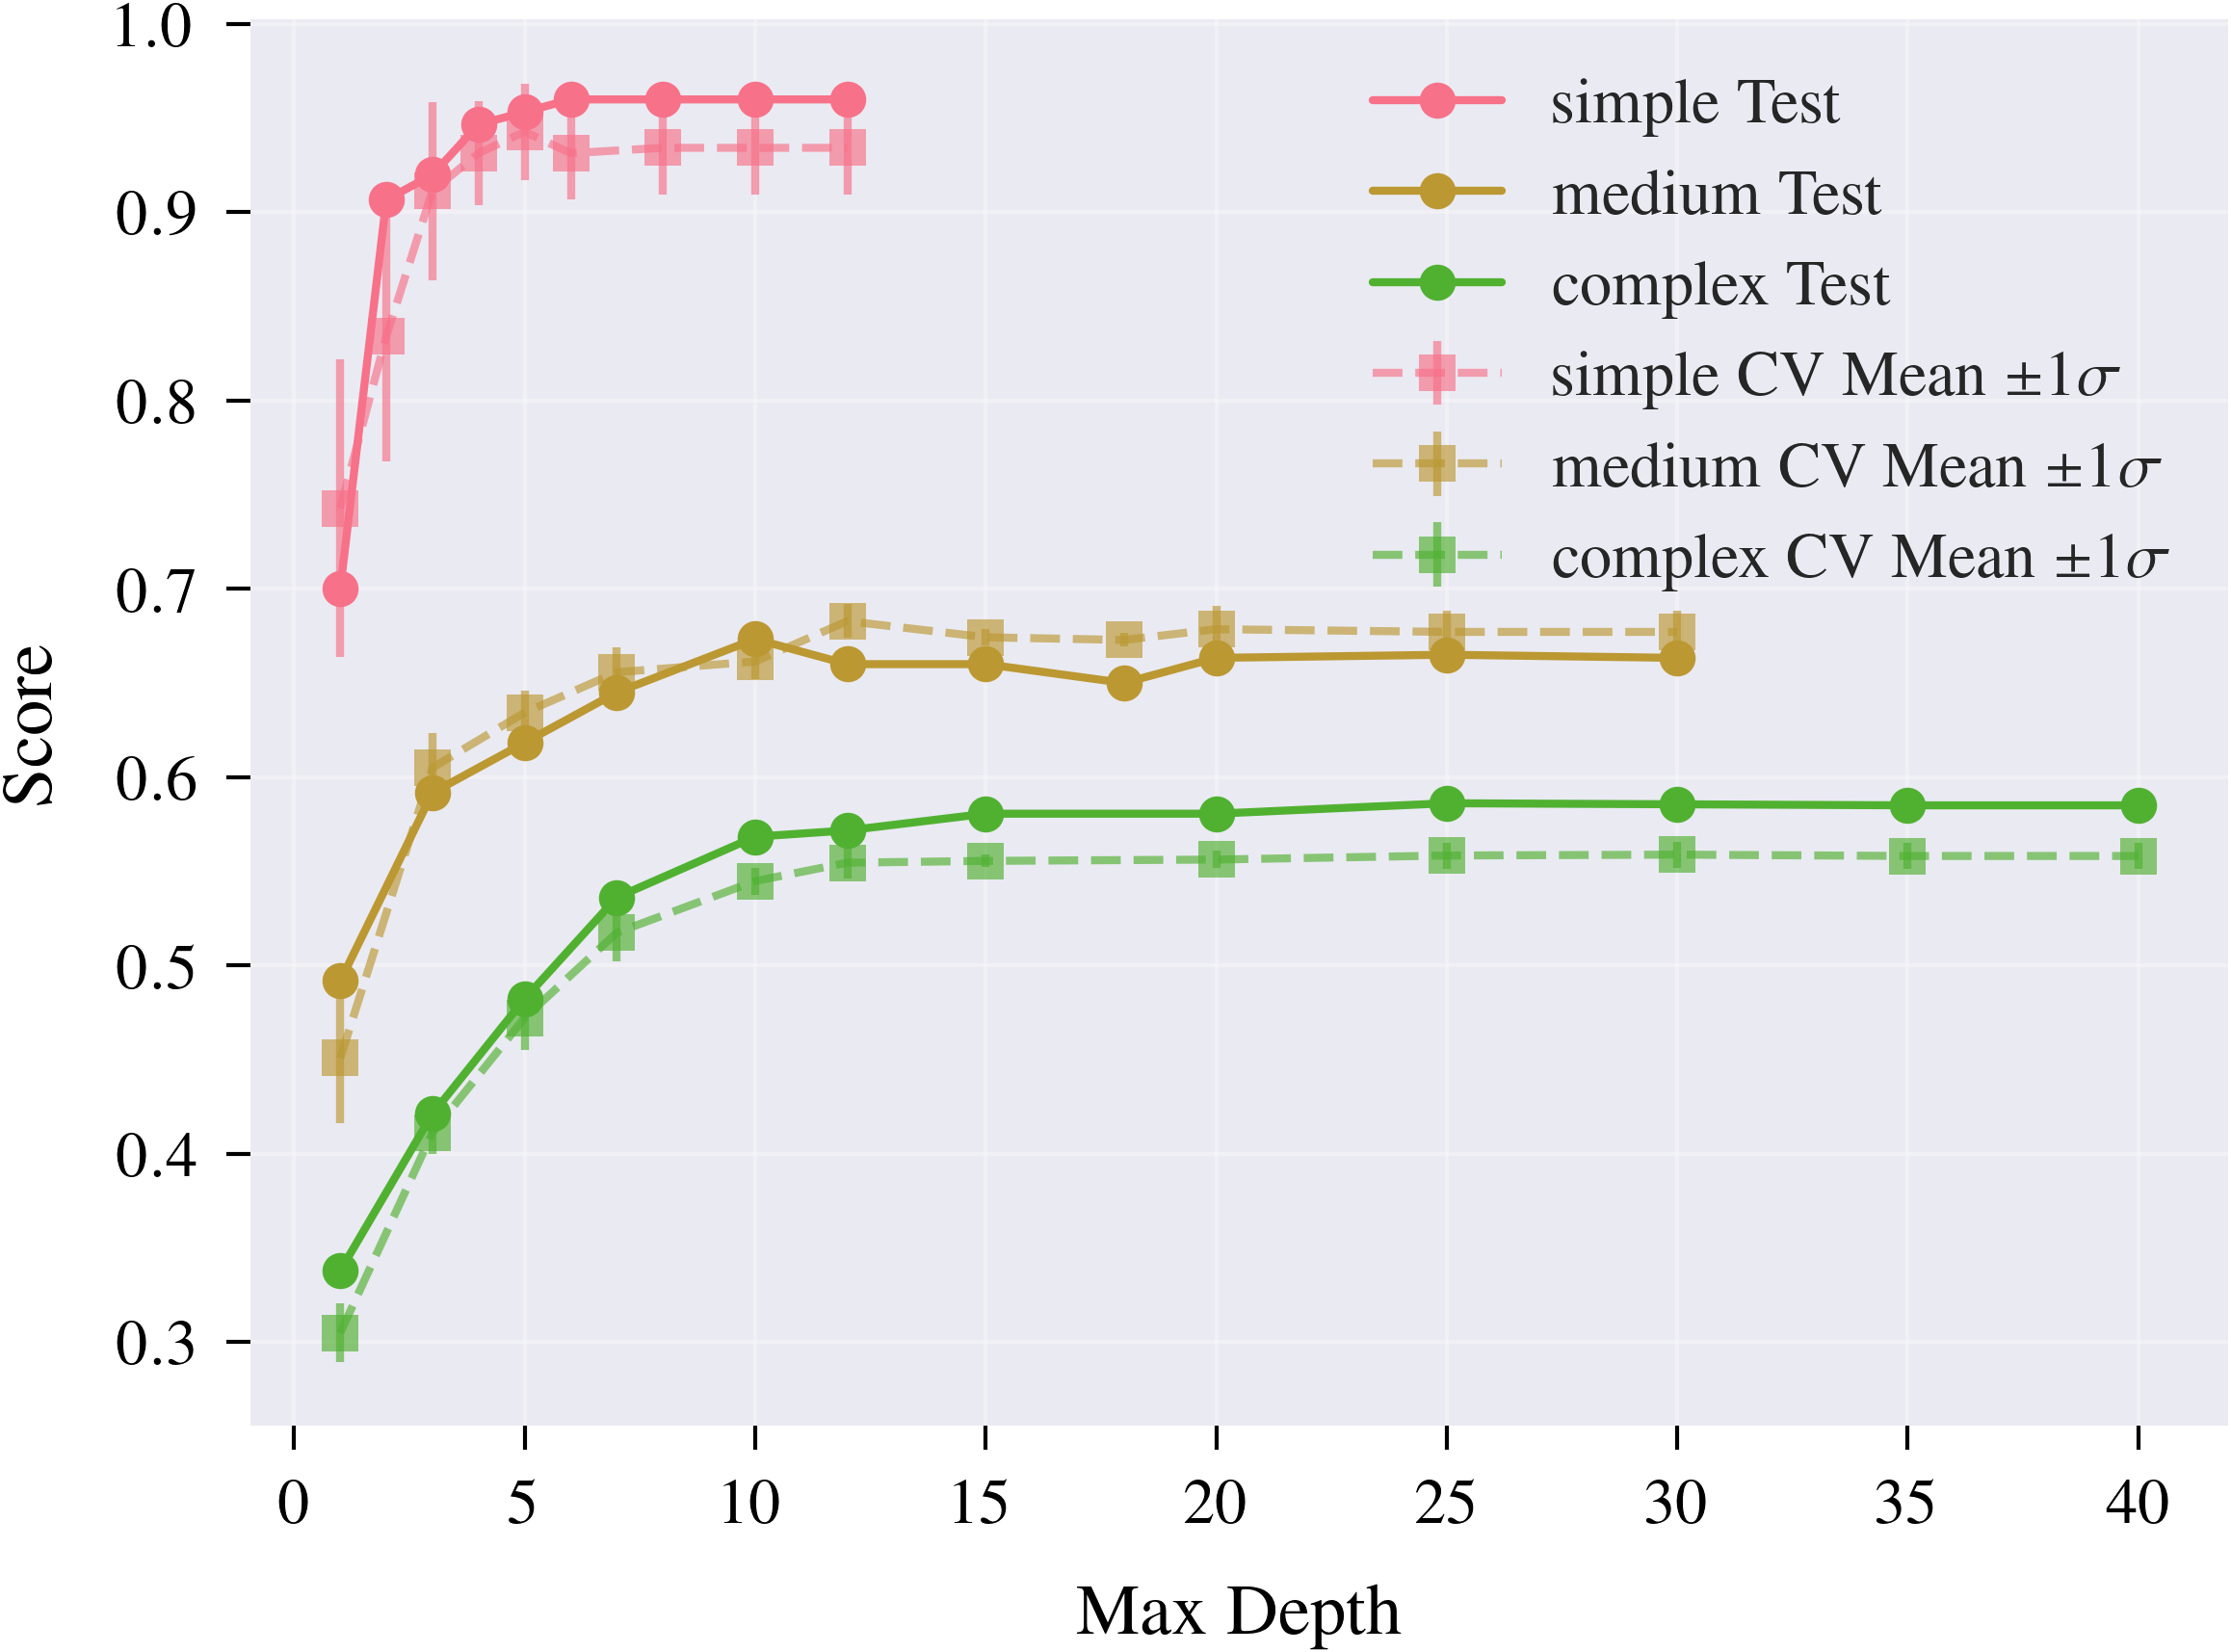

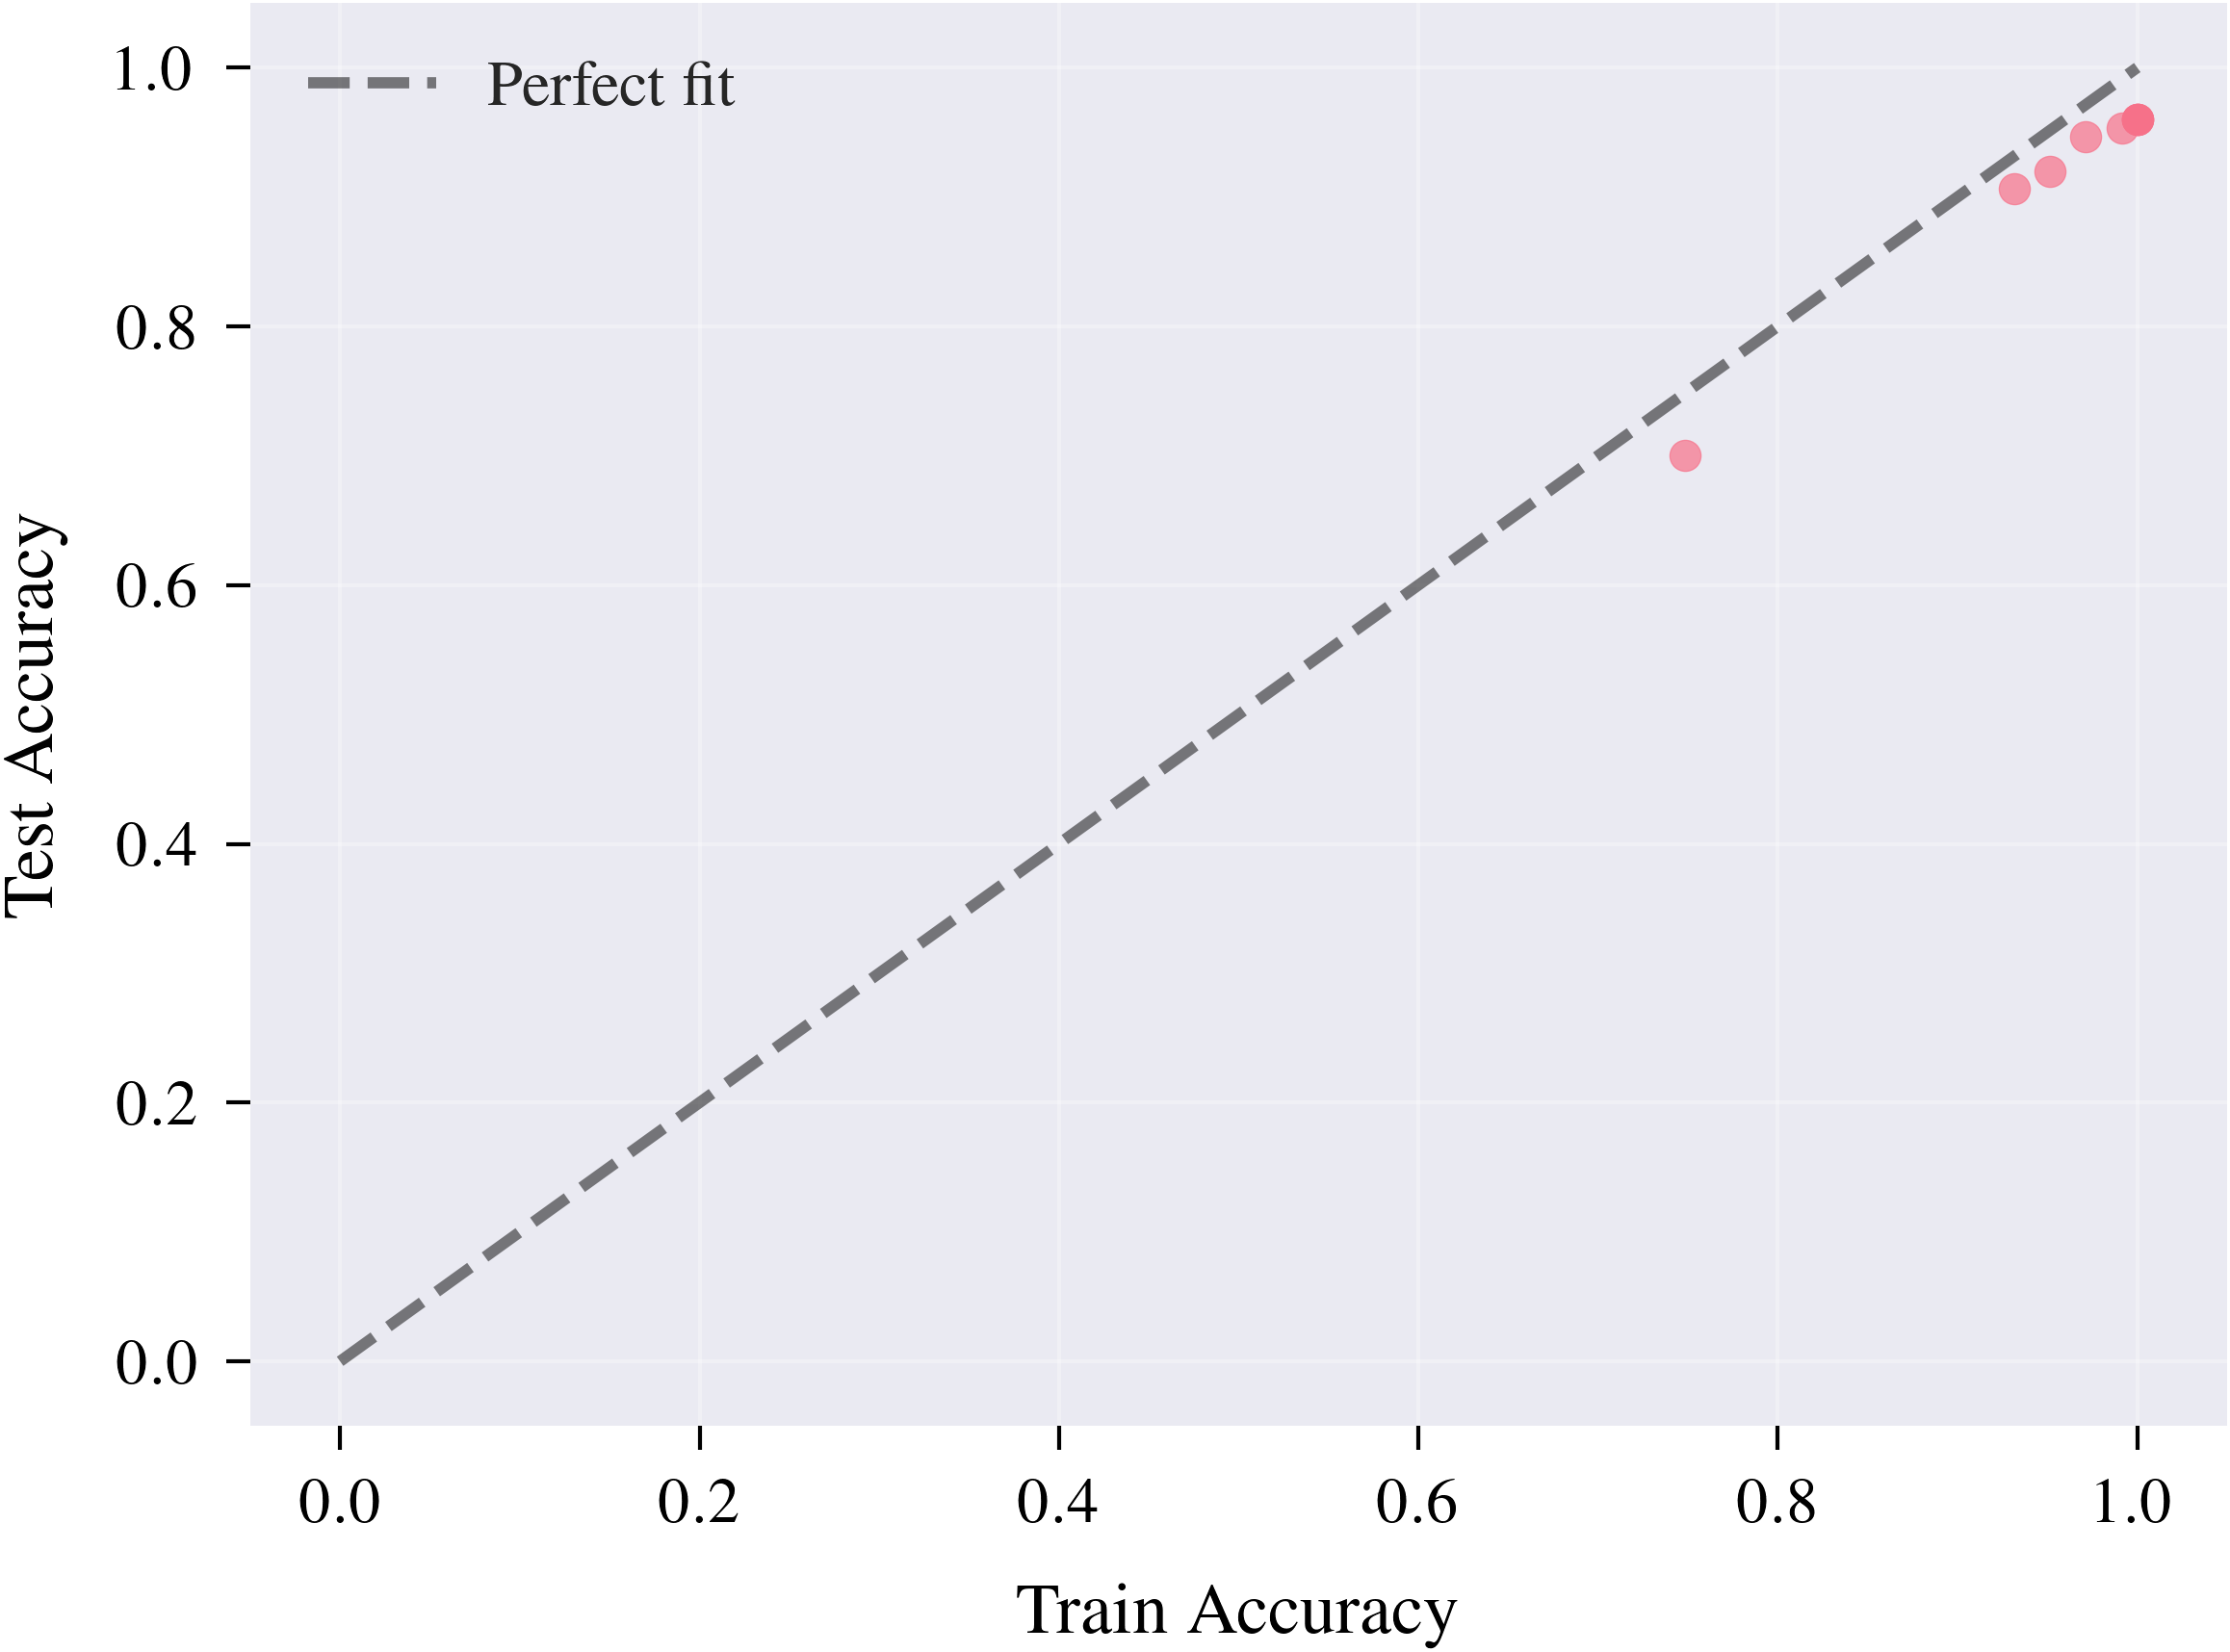

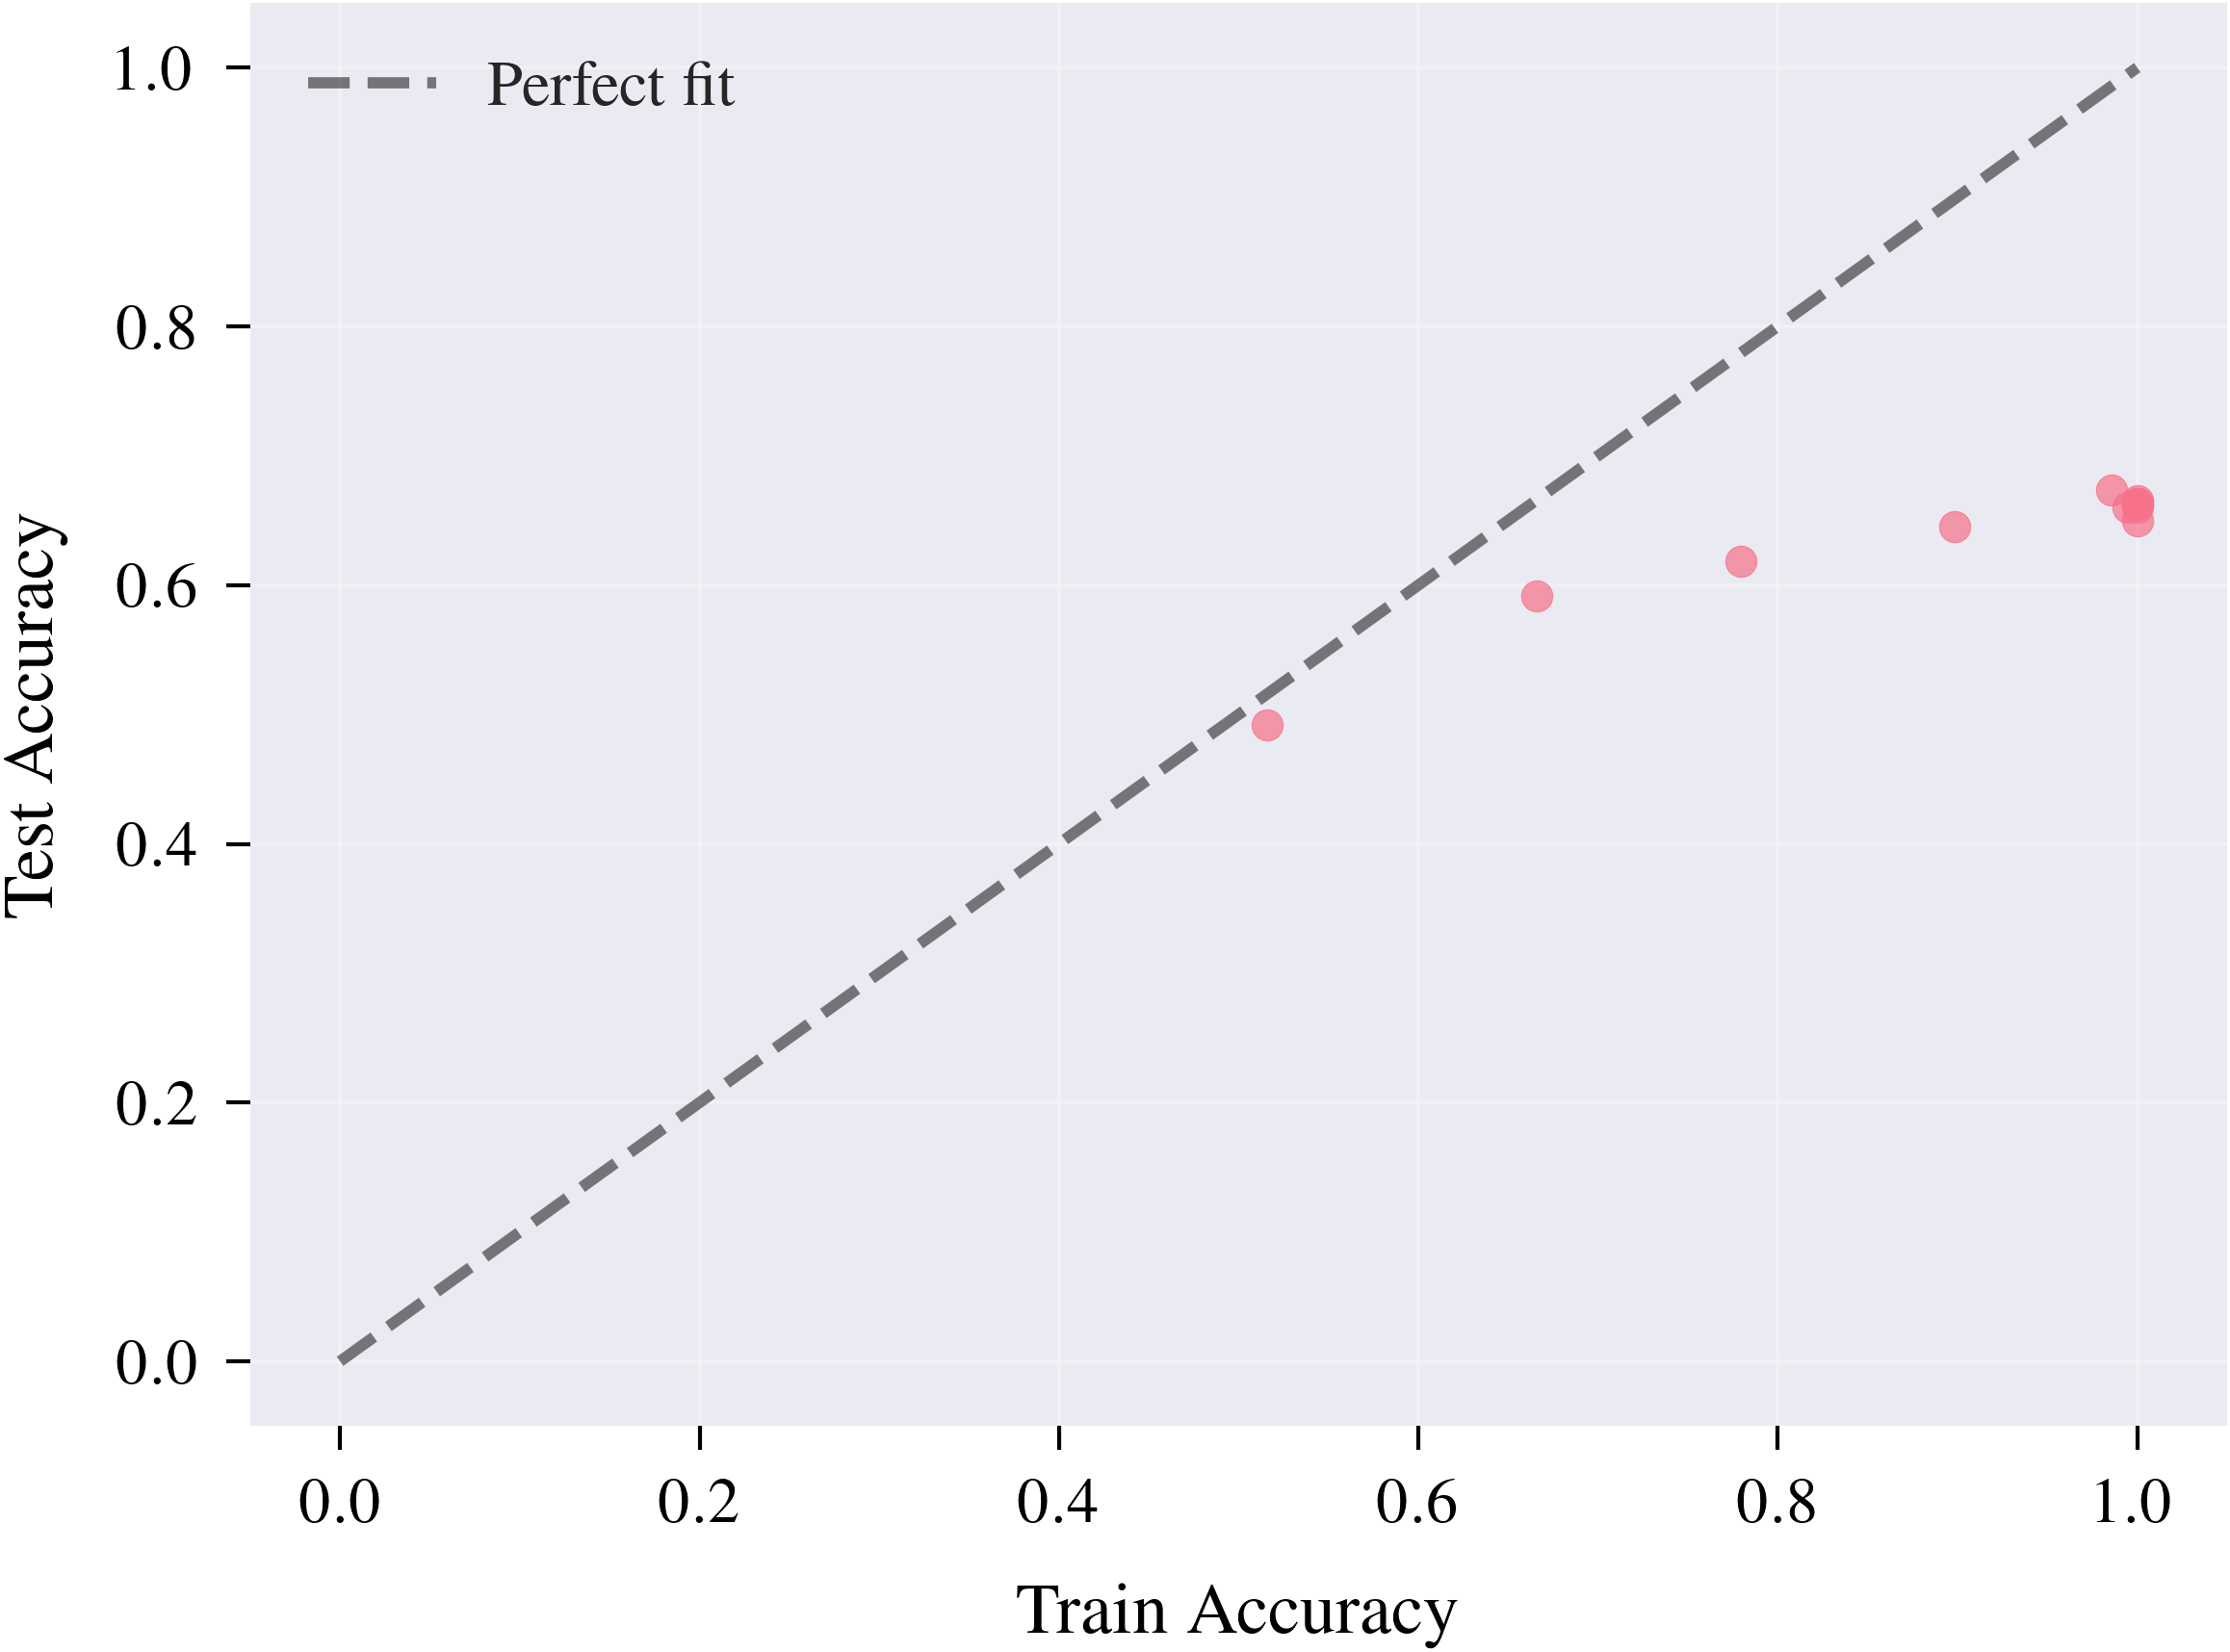

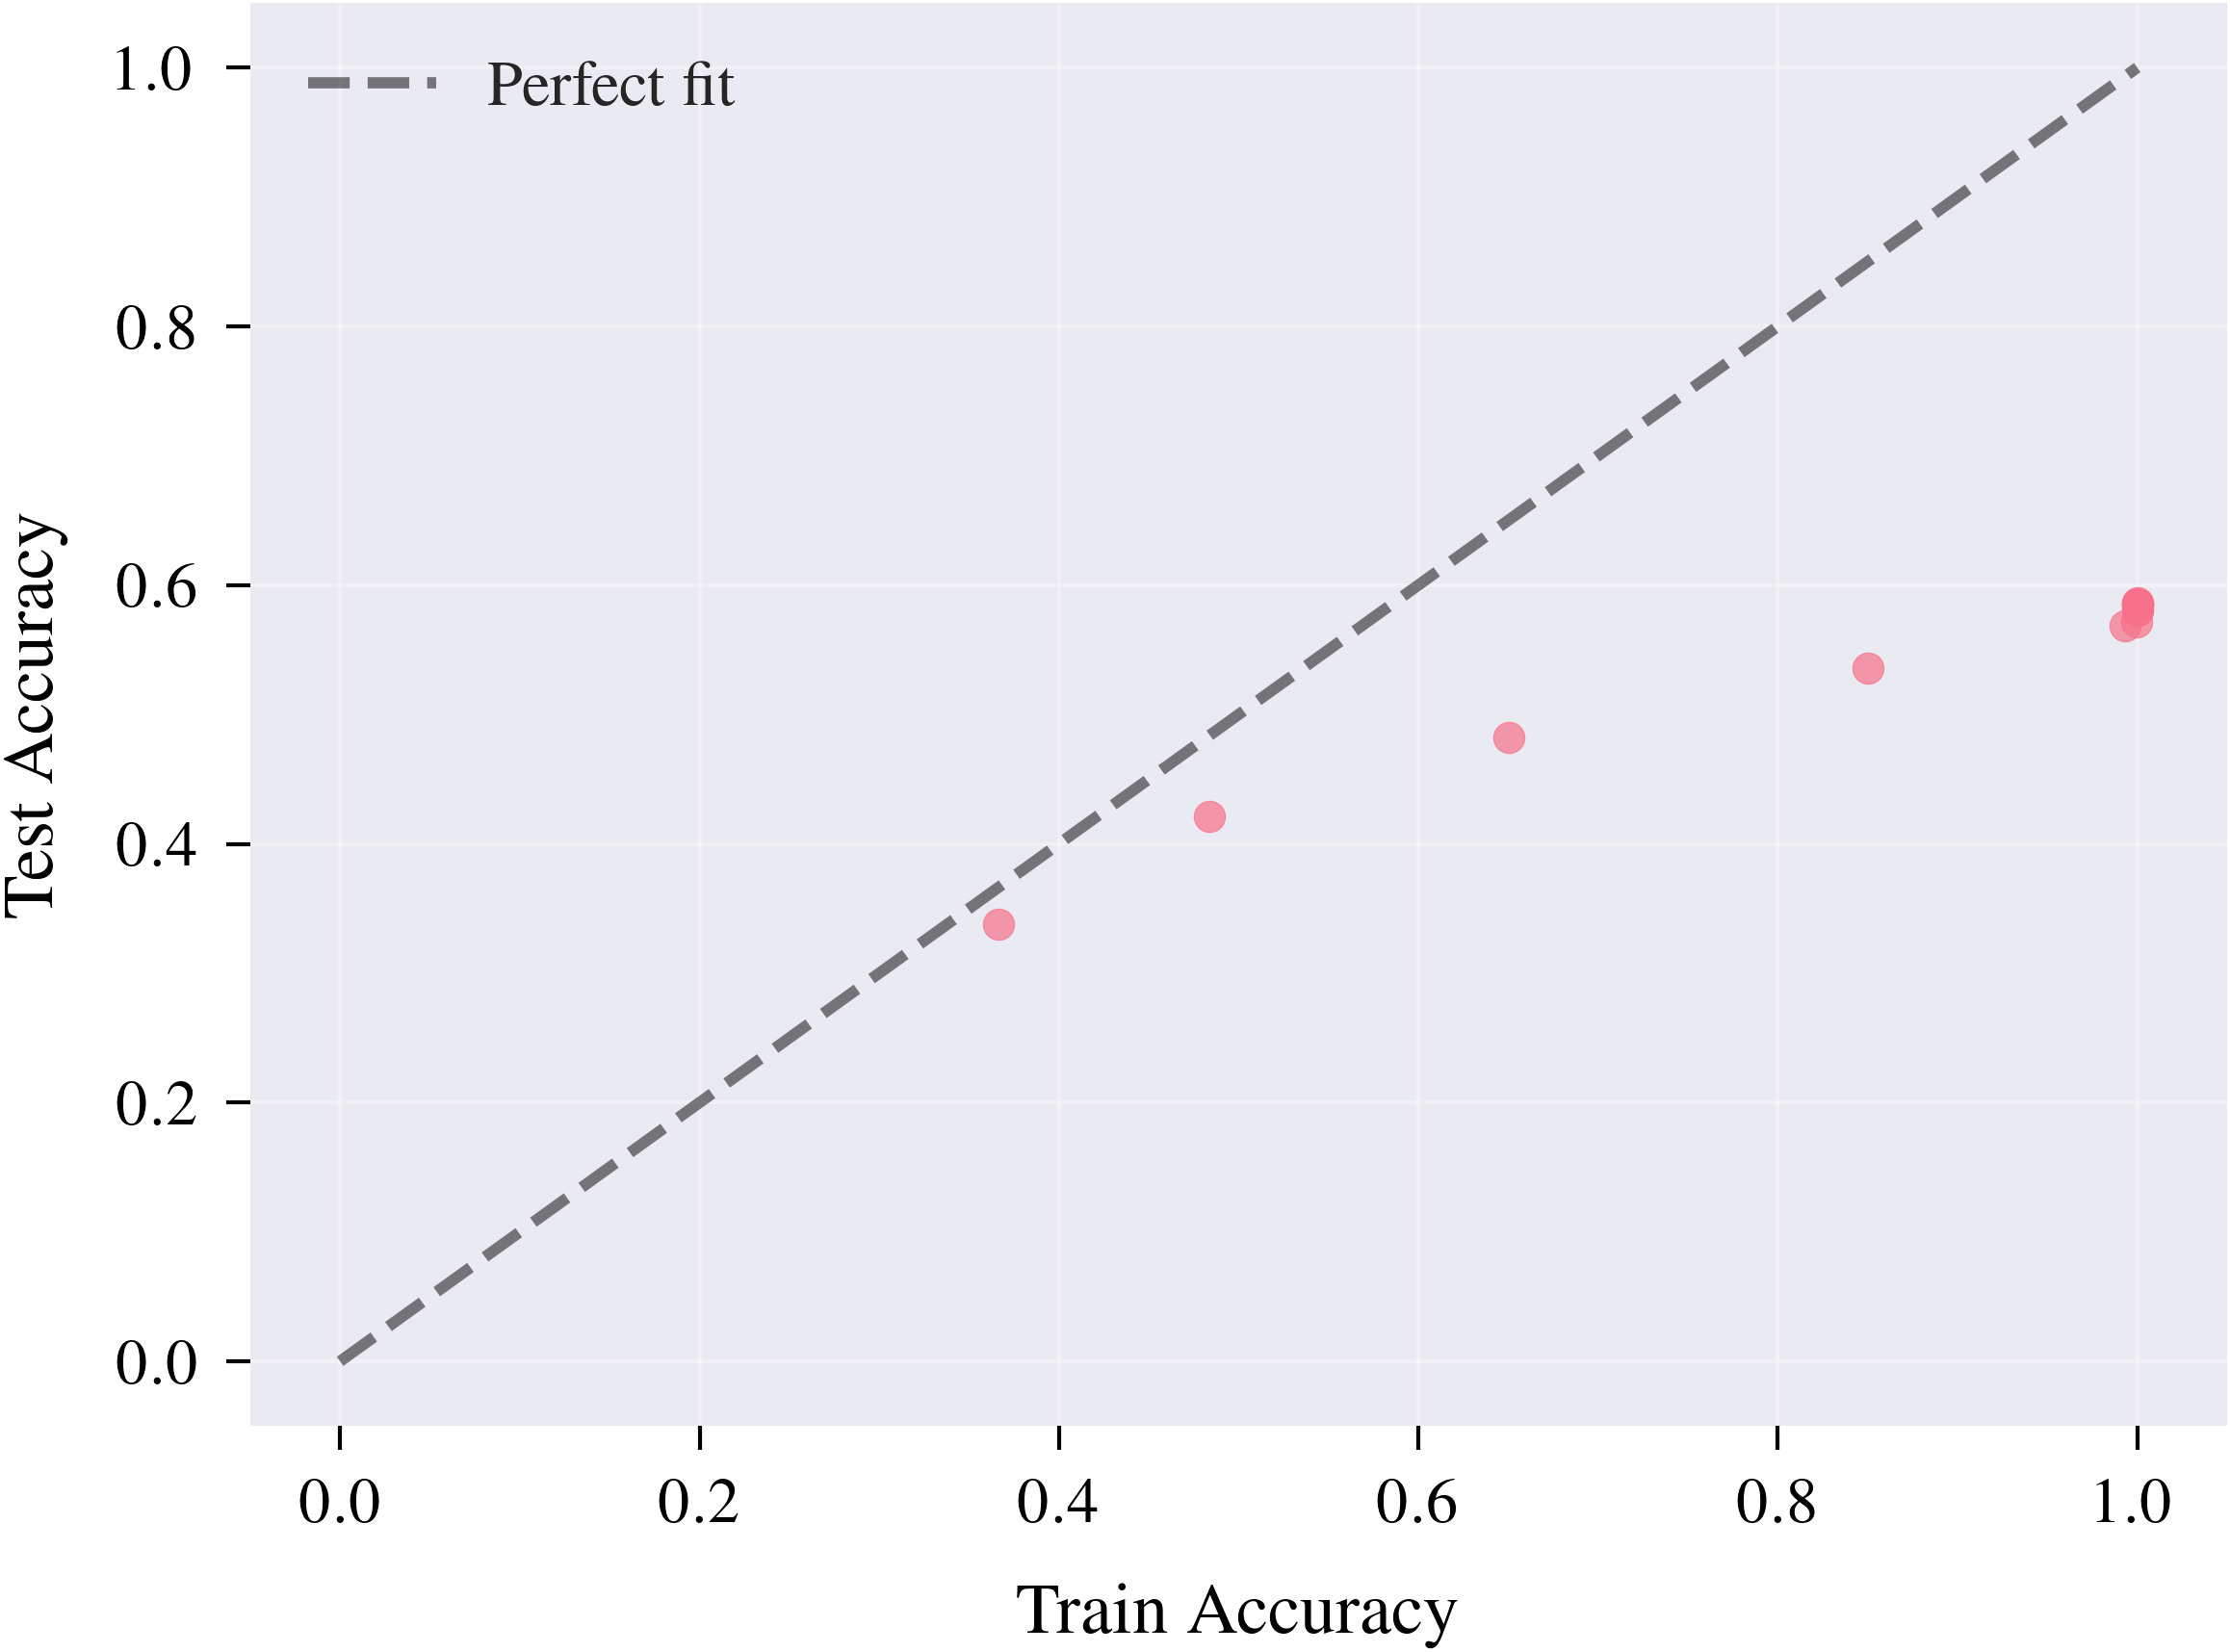

Test Accuracy Summary by Max Depth:


,Dataset,Max Depth,Mean Test Accuracy,Std Test Accuracy
0,simple,1,0.700000,0.0
1,simple,2,0.906667,0.0
2,simple,3,0.920000,0.0
3,simple,4,0.946667,0.0
4,simple,5,0.953333,0.0
5,simple,6,0.960000,0.0
6,simple,8,0.960000,0.0
7,simple,10,0.960000,0.0
8,simple,12,0.960000,0.0
9,medium,1,0.491667,0.0


In [90]:
print("\n1. Tree Depth Analysis Visualization:")
plot_depth_analysis(depth_results)

In [ ]:
def plot_overfitting_gap(results, datasets=('medium', 'complex')):
    for ds in datasets:
        rows = results['tree_depth'][ds]
        depths = [str(r['max_depth']) for r in rows]
        train = [r['train_accuracy'] for r in rows]
        test = [r['test_accuracy'] for r in rows]
        gap = [tr - te for tr, te in zip(train, test)]
        fig, ax1 = plt.subplots(figsize=(8, 4))
        ax1.plot(depths, train, marker='o', label='Train')
        ax1.plot(depths, test, marker='o', label='Test')
        ax1.set_xlabel('Max depth')
        ax1.set_ylabel('Accuracy')
        ax2 = ax1.twinx()
        ax2.plot(depths, gap, marker='s', linestyle='--', color='tab:red', label='Gap')
        ax2.set_ylabel('Train-Test gap')
        ax1.legend(loc='upper left'); ax2.legend(loc='upper right')
        plt.tight_layout(); plt.show()

plot_overfitting_gap(analyzer.results, datasets=('medium','complex'))


## Section 4: Experiment 2 - Feature Selection Analysis

**Objective**: Explore the impact of the number of randomly selected features for splits

**Fixed Parameters**: 
- Number of trees (n_estimators)
- Tree depth (use optimal from Experiment 1, or None)
- Bootstrap sampling

**Variable Parameter**: max_features (from 1 feature to all features)

**Expected Observations**:
- Few features: Higher variance between trees, better ensemble diversity
- Many features: Lower variance between trees, potential overfitting
- Optimal features: Balance between diversity and individual tree performance

In [39]:
# Experiment 2: Feature Selection Analysis
print("="*60)
print("EXPERIMENT 2: FEATURE SELECTION ANALYSIS")
print("="*60)

# Run experiment across all datasets
feature_results = analyzer.experiment_feature_selection(
    dataset_manager.splits,
    verbose=True
)

print("\n" + "="*60)
print("EXPERIMENT 2 COMPLETED")
print("="*60)

EXPERIMENT 2: FEATURE SELECTION ANALYSIS

Analyzing feature selection impact on simple dataset...
Total features: 10, Testing: [1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50]
  Features  1: Train=0.991, Test=0.947, CV=0.949+/-0.017
  Features  2: Train=0.989, Test=0.940, CV=0.949+/-0.036
  Features  3: Train=0.989, Test=0.947, CV=0.949+/-0.023
  Features  5: Train=0.997, Test=0.967, CV=0.949+/-0.036
  Features  7: Train=0.986, Test=0.953, CV=0.951+/-0.031
  Features 10: Train=0.991, Test=0.953, CV=0.943+/-0.026

Analyzing feature selection impact on medium dataset...
Total features: 25, Testing: [1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50]
  Features  1: Train=0.933, Test=0.628, CV=0.637+/-0.010
  Features  2: Train=0.932, Test=0.660, CV=0.665+/-0.010
  Features  3: Train=0.937, Test=0.655, CV=0.671+/-0.016
  Features  5: Train=0.946, Test=0.662, CV=0.664+/-0.020
  Features  7: Train=0.951, Test=0.690, CV=0.670+/-0.012
  Features 10: Train=0.950, Test=0.673, CV=0.663+/-0.014

In [91]:
def plot_feature_analysis(results, figsize=None, save_dir='feature_plots'):
    """Visualize number of features vs performance; larger IEEE double-column figure."""
    os.makedirs(save_dir, exist_ok=True)
    if figsize is None:
        figsize = (IEEE_DOUBLE_COL, IEEE_DOUBLE_COL * 0.75)

    plt.figure(figsize=figsize)
    palette = sns.color_palette(n_colors=len(results))
    for (color, (dataset_name, dataset_results)) in zip(palette, results.items()):
        rows = sorted(dataset_results, key=lambda r: (r['max_features'] is None, r['max_features']))
        features  = [r['max_features'] for r in rows]
        test_accs = [r['test_accuracy'] for r in rows]
        cv_means  = [r['cv_mean'] for r in rows]
        cv_stds   = [r['cv_std'] for r in rows]

        plt.plot(features, test_accs, marker='o', linewidth=1.8, color=color, label=f"{dataset_name} Test")
        plt.errorbar(
            features, cv_means, yerr=cv_stds,
            fmt='s--', capsize=4, linewidth=1.8, color=color, alpha=0.65,
            label=rf"{dataset_name} CV Mean $\pm 1\sigma$"
        )

    plt.xlabel("Max Features per Split")
    plt.ylabel("Score")
    plt.legend(frameon=False, handlelength=1.6, columnspacing=1.0, borderpad=0.3)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{save_dir}/all_datasets_accuracy_vs_features.png")
    plt.show()


2. Feature Selection Analysis Visualization:


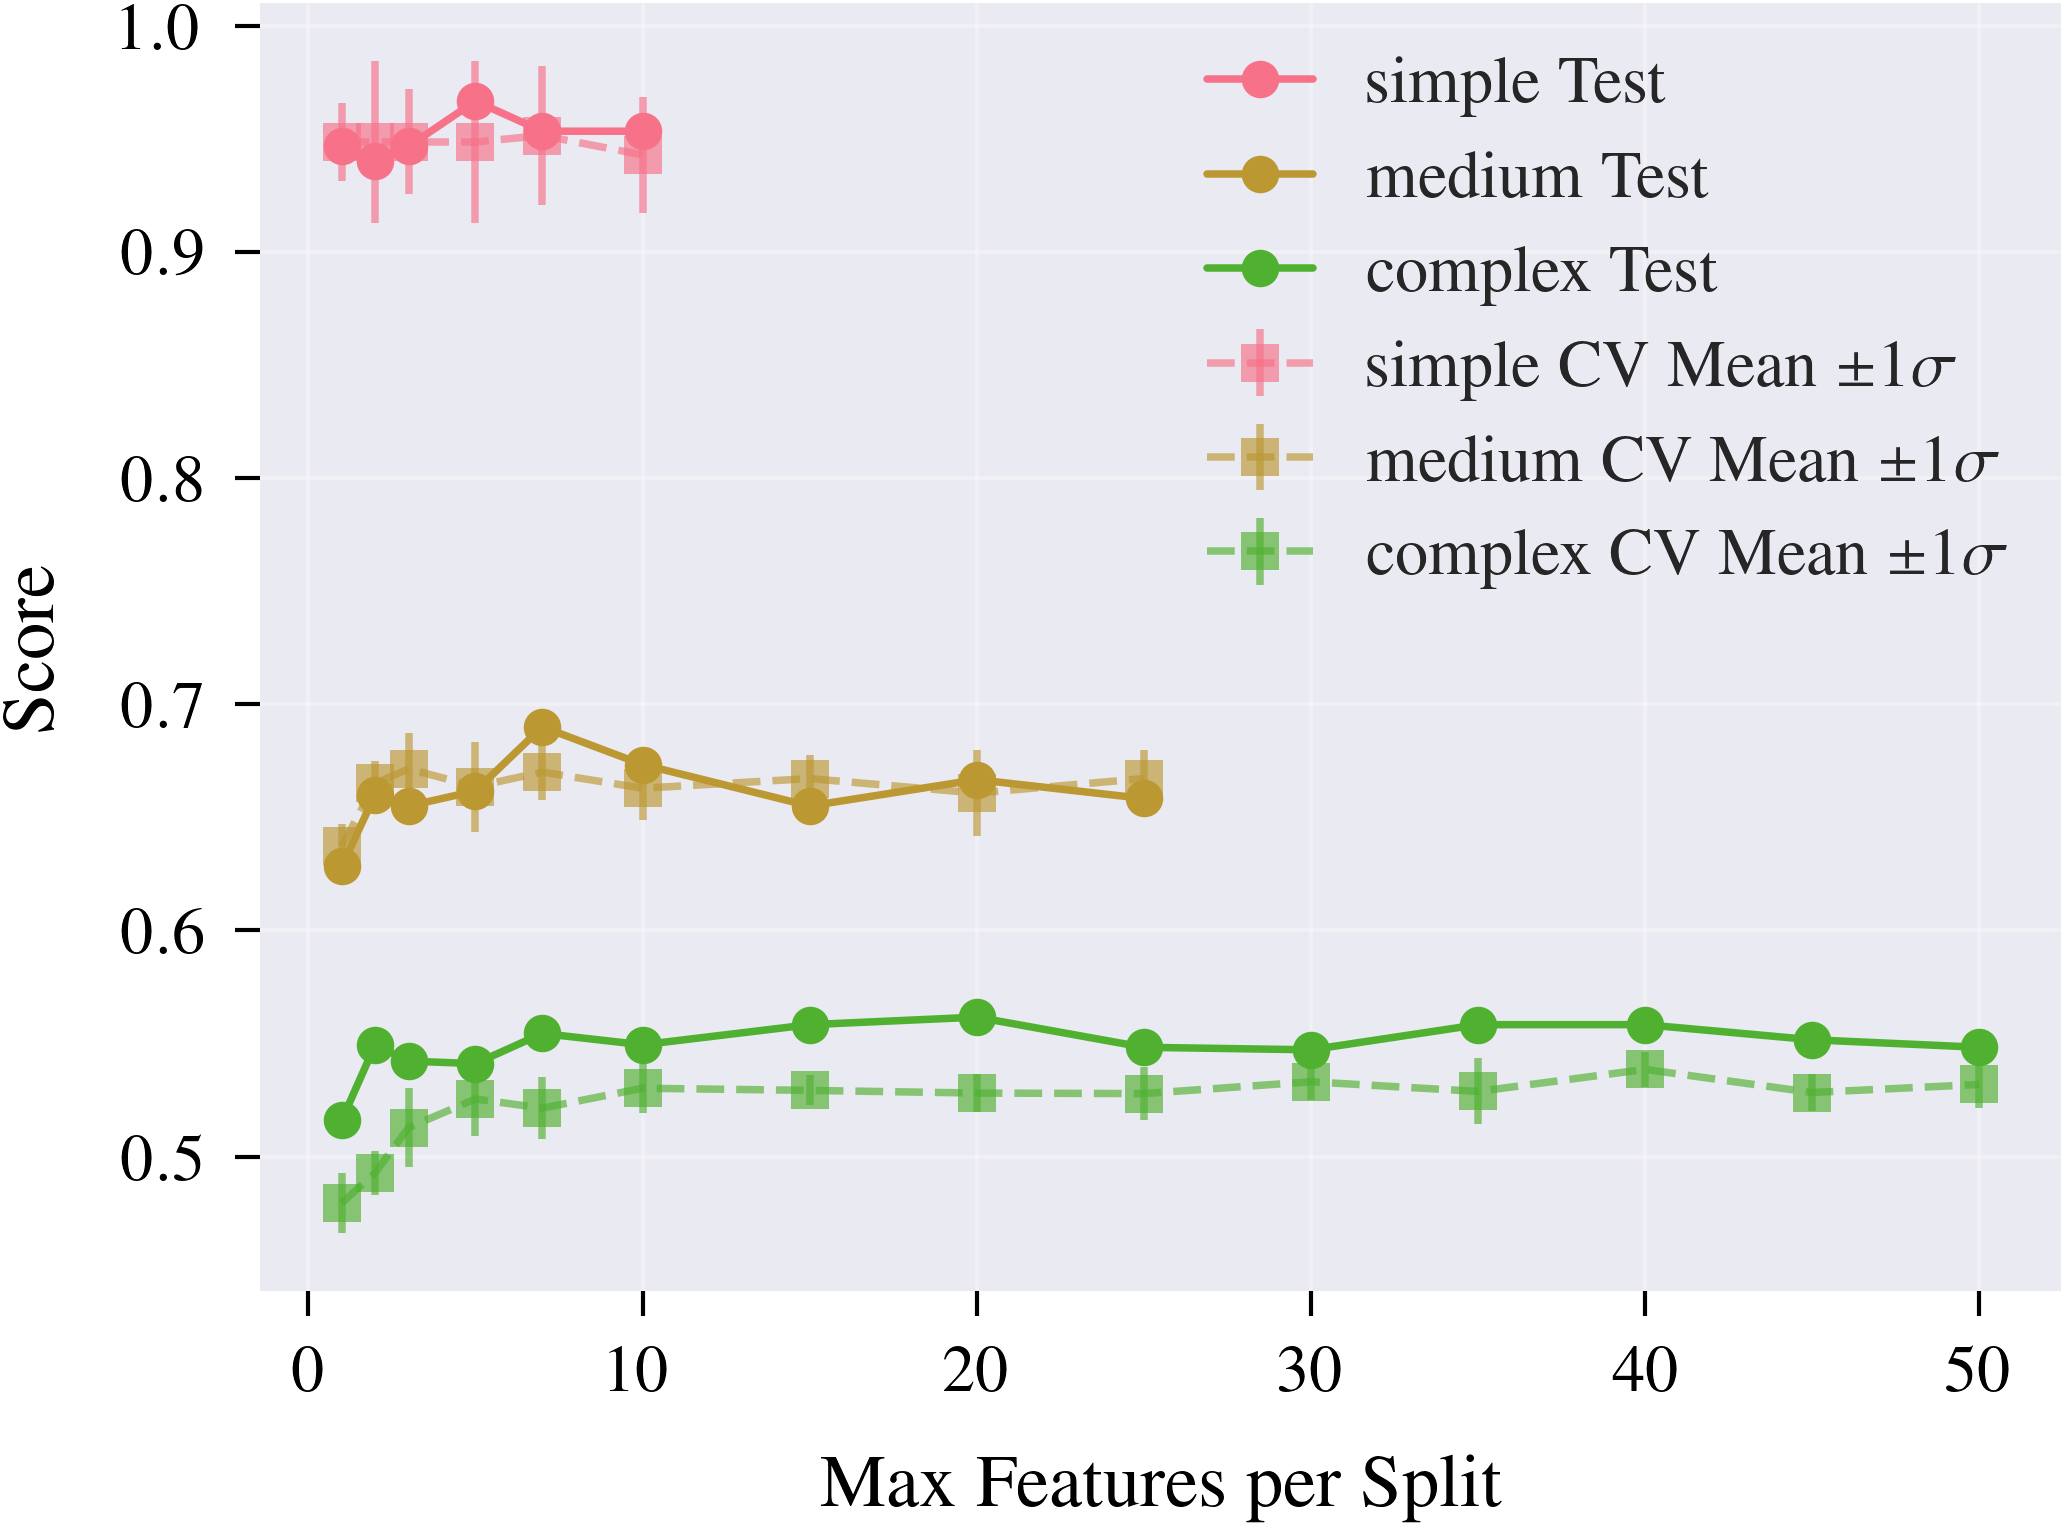

In [92]:
print("\n2. Feature Selection Analysis Visualization:")
plot_feature_analysis(feature_results)

## Section 5: Experiment 3 - Interaction Analysis of tree depth and number of trees

**Objective**: Explore the combined impact of tree depth AND number of trees

**Variable Parameters**: max_depth AND max_features (grid search)

**Expected Observations**:
- I expect that the number of trees will matter up until a point, where it will stagnate in performance.
- The number of trees will be influenced by the depth of the trees

In [94]:
# Experiment 3: Feature Selection Analysis
print("="*60)
print("EXPERIMENT 3: FEATURE SELECTION ANALYSIS")
print("="*60)

# Run experiment across all datasets
tree_depth_vs_num_trees = analyzer.experiment_tree_depth_vs_num_trees(
    dataset_manager.splits,
    verbose=False
)

print("\n" + "="*60)
print("EXPERIMENT 3 COMPLETED")
print("="*60)

EXPERIMENT 3: FEATURE SELECTION ANALYSIS


KeyboardInterrupt: 

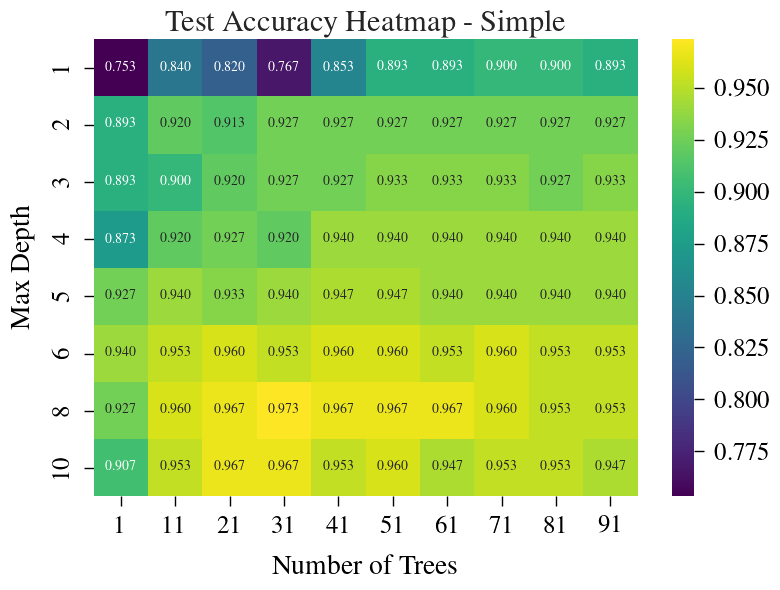

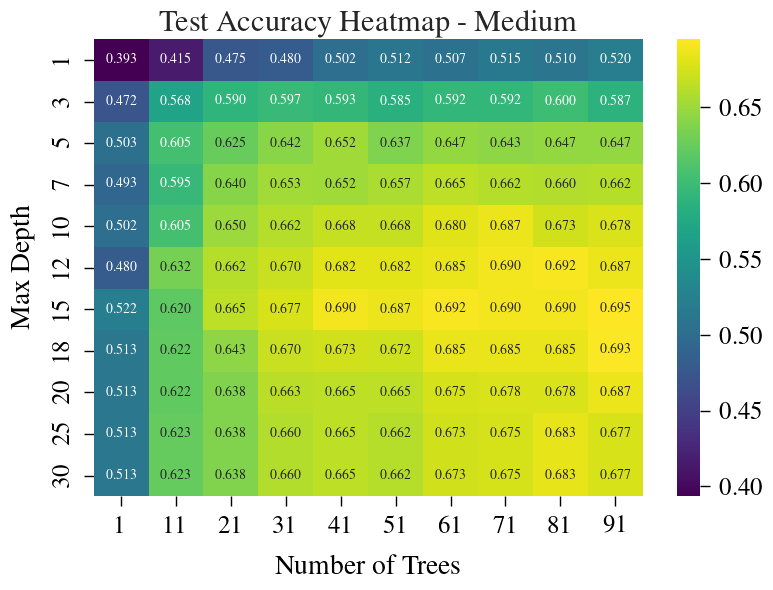

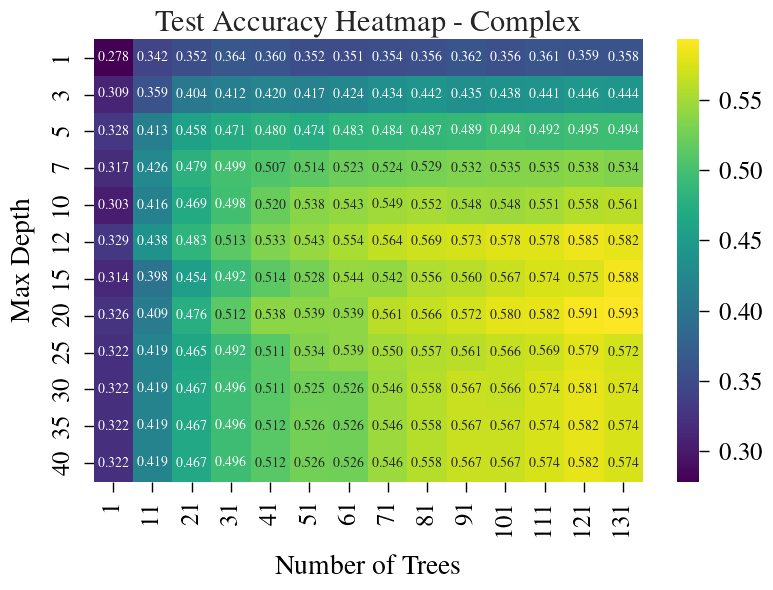

In [ ]:

def plot_tree_depth_vs_num_trees_heatmap(results, figsize=(8, 6)):
    dataset_names = list(results.keys())

    for dataset_name in dataset_names:
        dataset_results = results[dataset_name]
        if dataset_name == 'simple':
            depths = sorted([d for d in set(r['max_depth'] for r in dataset_results) if d is not None and d <= 10])
        else:
            depths = sorted(list(set([r['max_depth'] for r in dataset_results])))
        n_trees = sorted(list(set([r['n_estimator'] for r in dataset_results])))

        # Prepare heatmap data
        heatmap_data = np.zeros((len(depths), len(n_trees)))
        for r in dataset_results:
            if r['max_depth'] in depths and r['n_estimator'] in n_trees:
                d_idx = depths.index(r['max_depth'])
                t_idx = n_trees.index(r['n_estimator'])
                heatmap_data[d_idx, t_idx] = r['test_accuracy']

        plt.figure(figsize=figsize)
        sns.heatmap(
            heatmap_data,
            annot=True,
            fmt=".3f",
            cmap='viridis',
            xticklabels=n_trees,
            yticklabels=[str(d) for d in depths],
            cbar=False
        )
        plt.xlabel('Number of Trees')
        plt.ylabel('Max Depth')
        plt.tight_layout()
        plt.savefig(f"{dataset_name}_depth_vs_trees_heatmap.pdf", bbox_inches='tight', dpi=300)
        plt.show()

plot_tree_depth_vs_num_trees_heatmap(tree_depth_vs_num_trees)

In [ ]:
optimal_estimators = {'complex': 360, 'medium': 100, 'simple': 25}  
optimal_depths = {'complex': 20, 'medium': 15, 'simple': 8}
optimal_numbers = {'complex': 15, 'medium': 7, 'simple': 5}

## Section 6: Experiment 4 - Interaction Analysis

**Objective**: Explore the combined impact of tree depth AND feature selection

**Fixed Parameters**: 
- Number of trees (n_estimators)
- Bootstrap sampling

**Variable Parameters**: max_depth AND max_features (grid search)

**Expected Observations**:
- Complex interactions between depth and feature selection
- Different optimal combinations for different dataset complexities
- Potential synergistic or antagonistic effects

In [ ]:
# Experiment 4: Interaction Analysis
print("="*60)
print("EXPERIMENT 4: DEPTH x FEATURES INTERACTION ANALYSIS")
print("="*60)


# Run interaction experiment
interaction_results = analyzer.experiment_ensemble_of_forests(
    dataset_manager.splits,
    optimal_estimators=optimal_estimators,
    optimal_depths=optimal_depths,
    optimal_numbers=optimal_numbers,
    verbose=True
)

print("\n" + "="*60)
print("EXPERIMENT 4 COMPLETED")
print("="*60)

EXPERIMENT 4: DEPTH x FEATURES INTERACTION ANALYSIS

Ensemble of forests analysis on simple dataset...
         Only Underfit: Train=0.991, Test=0.940, Overfit=0.051 CV=0.943+/-0.016 (op=8, n=31)
     Majority Underfit: Train=0.991, Test=0.933, Overfit=0.058 CV=0.954+/-0.028 (op=8, n=31)
              Balanced: Train=1.000, Test=0.960, Overfit=0.040 CV=0.946+/-0.031 (op=8, n=31)
      Majority Overfit: Train=1.000, Test=0.940, Overfit=0.060 CV=0.963+/-0.021 (op=8, n=31)
          Only Overfit: Train=1.000, Test=0.960, Overfit=0.040 CV=0.966+/-0.025 (op=8, n=31)

Ensemble of forests analysis on medium dataset...
         Only Underfit: Train=0.969, Test=0.655, Overfit=0.314 CV=0.669+/-0.025 (op=15, n=60)
     Majority Underfit: Train=0.984, Test=0.677, Overfit=0.307 CV=0.661+/-0.028 (op=15, n=60)
              Balanced: Train=1.000, Test=0.660, Overfit=0.340 CV=0.677+/-0.019 (op=15, n=60)
      Majority Overfit: Train=1.000, Test=0.652, Overfit=0.348 CV=0.672+/-0.026 (op=15, n=60)
     

In [ ]:
def plot_ensemble_of_forests_analysis(results, figsize=(8, 6)):
        """Visualize ensemble of forests experiment results"""

        n_datasets = len(results)

        for dataset_name, dataset_results in results.items():
            configs = [r['configuration'] for r in dataset_results]
            test_accs = [r['test_accuracy'] for r in dataset_results]
            overfitting = [r['overfitting'] for r in dataset_results]

            fig, ax = plt.subplots(figsize=figsize)
            bars = ax.bar(range(len(configs)), test_accs, alpha=0.7)
            ax.set_xlabel('Ensemble Configuration')
            ax.set_ylabel('Test Accuracy')
            ax.set_title(f'{dataset_name.capitalize()} - Test Accuracy')
            ax.set_xticks(range(len(configs)))
            ax.set_xticklabels([c.replace(' ', '\n') for c in configs], rotation=0, fontsize=10)
            ax.grid(True, alpha=0.3)

            # Color bars by performance
            max_acc = max(test_accs)
            for bar, acc in zip(bars, test_accs):
                if acc >= max_acc - 0.005:
                    bar.set_color('green')
                elif acc <= min(test_accs) + 0.005:
                    bar.set_color('red')
                else:
                    bar.set_color('orange')

            # Add accuracy values on top of bars
            for i, (bar, acc) in enumerate(zip(bars, test_accs)):
                ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.002,
                        f'{acc:.3f}', ha='center', va='bottom', fontsize=9)

            plt.tight_layout()
            plt.savefig(f"{dataset_name}_test_accuracy.pdf")
            plt.close(fig)
        # Print detailed analysis
        print("\n" + "="*80)
        print("ENSEMBLE OF FORESTS DETAILED ANALYSIS")
        print("="*80)
        
        for dataset_name, dataset_results in results.items():
            print(f"\n{dataset_name.upper()} DATASET:")
            print("-" * 50)
            
            best_config = max(dataset_results, key=lambda x: x['test_accuracy'])
            worst_config = min(dataset_results, key=lambda x: x['test_accuracy'])
            
            print(f"Best Configuration: {best_config['configuration']}")
            print(f"  Test Accuracy: {best_config['test_accuracy']:.4f}")
            print(f"  Overfitting: {best_config['overfitting']:.4f}")
            print(f"  Forest Composition:")
            for forest in best_config['forests']:
                depth_str = str(forest['max_depth']) if forest['max_depth'] else "∞"
                print(f"    - Depth {depth_str}: {forest['n_estimators']} trees, weight {forest['weight']}")
            
            print(f"\nWorst Configuration: {worst_config['configuration']}")
            print(f"  Test Accuracy: {worst_config['test_accuracy']:.4f}")
            print(f"  Overfitting: {worst_config['overfitting']:.4f}")
            
            # Individual forest analysis for best configuration
            print(f"\nIndividual Forest Performance (Best Config):")
            for i, analysis in enumerate(best_config['individual_forest_analysis']):
                depth_str = str(analysis['max_depth']) if analysis['max_depth'] else "∞"
                print(f"  Forest {i+1} (Depth {depth_str}): Train={analysis['train_accuracy']:.3f}, "
                    f"Test={analysis['test_accuracy']:.3f}, Weight={analysis['weight']}")


        

def print_best_configurations(self):
    """Print best configurations for each experiment and dataset"""
    print("="*80)
    print("BEST CONFIGURATIONS SUMMARY")
    print("="*80)
    
    for exp_name, exp_results in self.results.items():
        print(f"\n{exp_name.upper().replace('_', ' ')} EXPERIMENT:")
        print("-" * 50)
        
        for dataset_name, dataset_results in exp_results.items():
            # Find best configuration based on CV score
            best_result = max(dataset_results, key=lambda x: x['cv_mean'])
            
            print(f"\n{dataset_name.capitalize()} Dataset:")
            print(f"  Best CV Score: {best_result['cv_mean']:.4f} +/- {best_result['cv_std']:.4f}")
            print(f"  Test Accuracy: {best_result['test_accuracy']:.4f}")
            print(f"  Train Accuracy: {best_result['train_accuracy']:.4f}")
            print(f"  Overfitting: {best_result['overfitting']:.4f}")
            
            # Print specific parameters
            if 'max_depth' in best_result:
                depth = best_result['max_depth'] if best_result['max_depth'] else "Unlimited"
                print(f"  Max Depth: {depth}")
            if 'max_features' in best_result:
                print(f"  Max Features: {best_result['max_features']}")


In [ ]:
print("\n4. Ensemble of Forests Analysis Visualization:")
plot_ensemble_of_forests_analysis(interaction_results)